In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
import SurfaceTopography.Uniform.GeometryAnalysis as CAA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy import interpolate

In [2]:
from ContactMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from SurfaceTopography import Topography
from SurfaceTopography import make_sphere
from ContactMechanics.Factory import make_system
from ContactMechanics.Systems import NonSmoothContactSystem
from ContactMechanics.Tools.Logger import screen

In [3]:
sx,sy= 4.8,4.8

In [4]:

Es =  1/np.pi #MPa
nu = 0.25
R = 1

In [54]:
def simulate(rays,amplitudes,n):
    nx, ny = n,n
    sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

    x, y = sphere.positions()
    x -= sx / 2
    y -= sy /2
    radius = np.sqrt(x ** 2 + y ** 2)

    #theta_out = np.zeros((nx,ny))
    #theta = np.arctan(y/x, out = theta_out, where = x!=0 )
    theta = np.arctan2(y,x)
    #h_m = 1/np.pi
    substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
    #r = np.sqrt((x*x)+(y*y))
    #h_m = r*r/(2*R)
    topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
    radial_waves = Topography(amplitudes*(np.cos(rays*theta)), physical_sizes=(sx,sy))
    topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

    system1 = make_system(substrate, topography1)
    system2 = make_system(substrate, topography)
    gtol = 1e-6
    penetration = 1.3
    sol1 = system1.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    sol2 = system2.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    u = system1.displacements = sol1.x
    gap = system1.compute_gap(u, penetration)

    force = - system1.substrate.evaluate_force(u)
    pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt

 
            
    return system1,system2

In [6]:
def geometry(system1,rays,n):
    nx,ny = n,n
    contact_area1 = system1.contact_zone
    #contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    #iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
    #ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    mask_min = 25
    mask_max = 40
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[(mask_min*rays):nx//2,(mask_min*rays):ny//2]=False  
    oper[nx//2:(mask_max*rays), ny//2:(mask_max*rays)] = False
    oper[(mask_min*rays):nx//2, ny//2:(mask_max*rays)] = False
    oper[nx//2:(mask_max*rays),(mask_min*rays):ny//2]=False
    #sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    
    
    
    X = x[oper]
    Y = y[oper]
    center = [np.mean(X), np.mean(X)]
    
    distances = []
    for i in range(len(X)):
        distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
        distances.append(distance)
    min_distance = min(distances)
    max_distance = max(distances)
    return min_distance,max_distance 

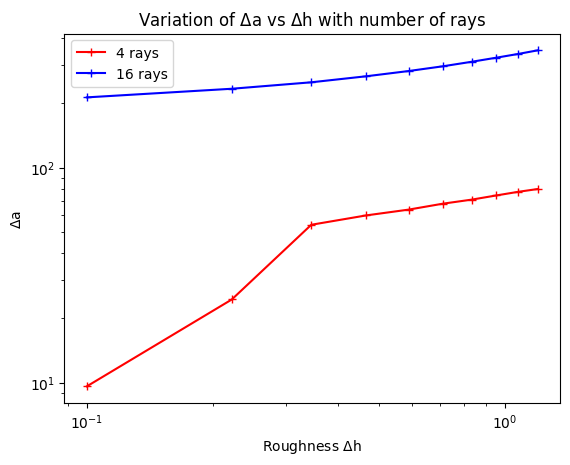

In [30]:
amplitudes = np.linspace(0.1,,10)
distor4 = np.zeros(len(amplitudes))
distor16 = np.zeros(len(amplitudes))
amp = np.zeros(len(amplitudes))


for i in range(len(amplitudes)):
   system4,Hertzsystem = simulate(4,amplitudes[i],256)
   system16,Hertzsystem = simulate(16,amplitudes[i],1024) 
   min_distance4,max_distance4 = geometry(system4,4,256)
   min_distance16,max_distance16 = geometry(system16,16,1024)
   distor4[i]=max_distance4-min_distance4
   distor16[i]=max_distance16-min_distance16
   amp[i] = amplitudes[i]  
plt.loglog(amp,distor4,"-+", color = 'red', label='4 rays')
plt.loglog(amp,distor16,"-+",color = 'blue', label='16 rays')
plt.title("Variation of $\Delta$a vs $\Delta$h with number of rays")    
plt.xlabel("Roughness $\Delta$h")
plt.ylabel("$\Delta$a")
plt.legend()

In [7]:
def a_vs_rays(amplitude):
    rays = [4,8,12,16,20,32]
    distor = np.zeros(len(rays))
    r = np.zeros(len(rays))
    for i in range(len(rays)):
        N = 64
        print(rays[i])
        system,Hertzsystem = simulate(rays[i],amplitude,N*rays[i])
        min_distance,max_distance = geometry(system,rays[i],N*rays[i])
        distor[i] = max_distance-min_distance
        r[i] = rays[i] 
    plt.plot(r,distor,"-+", label = 'Line with initial penetraion 1.2')
    plt.plot(r, (r**1), label='k$x^1$ line')
    plt.plot(r, (r**1.5), label='k$x^1.5$ line')
    plt.plot(r, (r**2), label='k$x^2$ line')
    plt.title("Relationship of $\Delta$a with number of rays at amplitude {:.2f}".format(amplitude))    
    plt.xlabel("Number of rays")
    plt.ylabel("$\Delta$a")
    plt.legend()


4
8
12
16
20
32


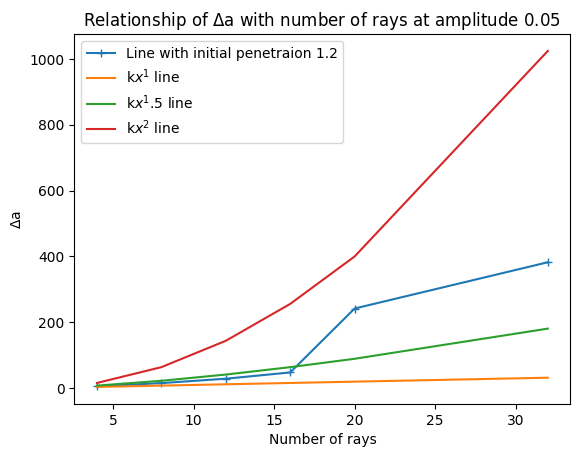

In [29]:
a_vs_rays(0.05)

In [29]:
def a_vs_h(min_amplitude, max_amplitude, rays, discretization):
    if(discretization==256):
        t=10
    else:
        t=6
    amplitudes = np.linspace(min_amplitude,max_amplitude,t)
    distor = np.zeros(len(amplitudes))
    amp = np.zeros(len(amplitudes))
    for i in range(len(amplitudes)):
        print(amplitudes[i])
        system,Hertzsystem = simulate(rays,amplitudes[i],discretization)
        min_distance,max_distance = geometry(system,rays,discretization)
        distor[i]=max_distance-min_distance
        amp[i] = amplitudes[i]
    plt.loglog(amp,distor,"-+", label='{:.0f} rays'.format(rays))
    plt.plot(amp, 85*(amp**0.9), color='red', label='k$x^1$ line')
    plt.title("$\Delta$a vs $\Delta$h with h varying from {:.2f}-{:.2f}".format(min_amplitude,max_amplitude))    
    plt.xlabel("Roughness $\Delta$h")
    plt.ylabel("$\Delta$a")
    plt.legend()

0.03
0.05444444444444445
0.0788888888888889
0.10333333333333333
0.12777777777777777
0.15222222222222223
0.17666666666666667
0.20111111111111113
0.22555555555555556
0.25


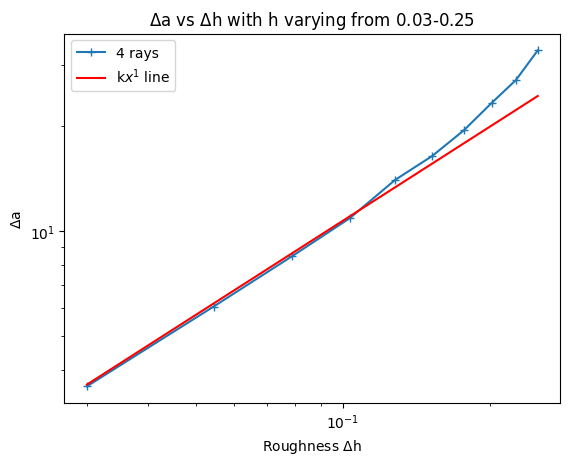

In [12]:
a_vs_h(0.03,0.25,4,256)

0.03
0.074
0.118
0.162
0.206
0.25


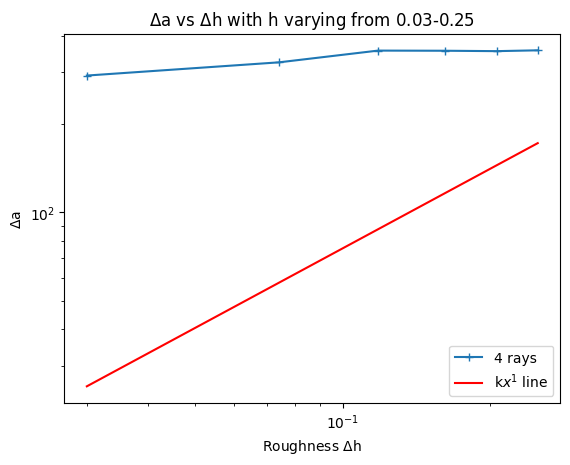

In [28]:
a_vs_h(0.03,0.25,4,1024)

0.006
0.0148
0.023600000000000003
0.0324
0.0412
0.05


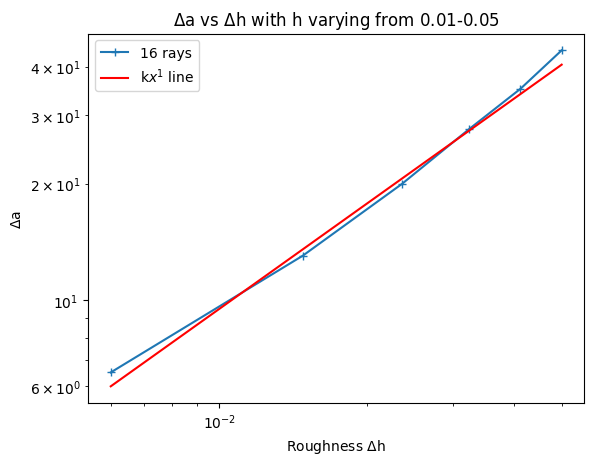

In [27]:
a_vs_h(0.006,0.05,16,1024)

In [61]:
def Contact_Perimeter(system1,system2,rays,n,amplitude):
    nx,ny = n,n
    contact_area1 = ~system1.contact_zone
    contact_area2 = ~system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    mask_min = 25
    mask_max = 40
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[(mask_min*rays):nx//2,(mask_min*rays):ny//2]=False 
    oper[nx//2:(mask_max*rays), ny//2:(mask_max*rays)] = False
    oper[(mask_min*rays):nx//2, ny//2:(mask_max*rays)] = False
    oper[nx//2:(mask_max*rays),(mask_min*rays):ny//2]=False
    sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    fig, ax = plt.subplots()
    ax.imshow(contact_area1, cmap="Greys")
    ax.plot(x[oper], y[oper], ".b", mfc="none",label="Perimeter for amplitude {:.3f}, nn".format(amplitude))
    ax.plot(x[sper], y[sper], ".r", mfc="none",label="Hertzian_perimeter, nn")
    ax.legend()

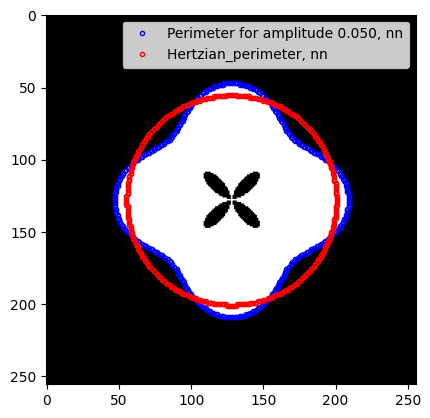

In [62]:
system,Hertzsys = simulate(4,0.2,256)
Contact_Perimeter(system,Hertzsys,4,256,0.05)

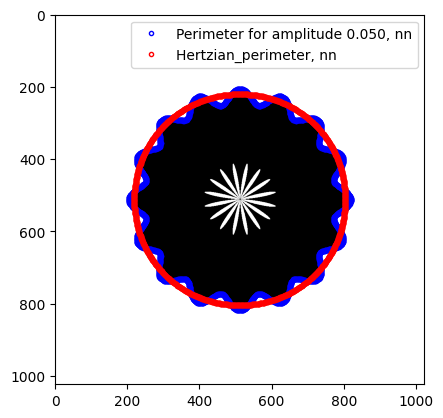

In [31]:
system,Hertzsys = simulate(16,0.05,1024)
Contact_Perimeter(system,Hertzsys,16,1024,0.05)

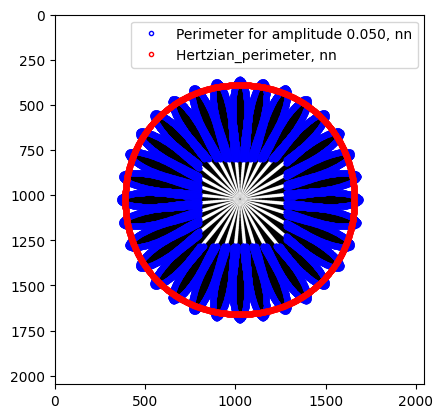

In [216]:
system,Hertzsys = simulate(32,0.05,2048)
Contact_Perimeter(system,Hertzsys,32,2048,0.05)